In [ ]:
!pip install Sastrawi -q

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from google.colab import files

In [ ]:
# Dataset "data_gabungan_gojek_100k.csv"
!gdown 1ltFf7W-tIV97BcJalwdKFAzTowNbkWfd
# Kamus tidak baku.csv
!gdown 1nhmkDspn2cU8RtpCGPdxfK4U6kxlzRaw
# id.stopwords.02.01.2016.txt
!gdown 19XbX8h0Z-wWGBNhdfHH-N-AvTicgIVDk

Downloading...
From: https://drive.google.com/uc?id=1ltFf7W-tIV97BcJalwdKFAzTowNbkWfd
To: /content/data_gabungan_gojek_100k.csv
100% 11.6M/11.6M [00:00<00:00, 164MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nhmkDspn2cU8RtpCGPdxfK4U6kxlzRaw
To: /content/tidak baku.csv
100% 196k/196k [00:00<00:00, 65.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=19XbX8h0Z-wWGBNhdfHH-N-AvTicgIVDk
To: /content/id.stopwords.02.01.2016.txt
100% 6.45k/6.45k [00:00<00:00, 15.3MB/s]


In [ ]:
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

In [ ]:
slang_df = pd.read_csv('tidak baku.csv', header=0)
slang_dict = dict(zip(slang_df['slang'], slang_df['formal']))

with open('id.stopwords.02.01.2016.txt', 'r') as f:
    custom_stopwords = set(f.read().splitlines())

In [ ]:
nltk_stopwords = set(stopwords.words('indonesian'))
all_stopwords = nltk_stopwords.union(custom_stopwords)

factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
df_original = pd.read_csv('data_gabungan_gojek_100k.csv')
print(f"\nTotal baris: {len(df_original)}")
print(df_original.head())

df = df_original.copy()


Total baris: 100000
                                             content  score  \
0  Lg eror y di dwonload ko gagal terus udah di d...      2   
1   diskon buat game Mobile legends nya di perbanyak      5   
2  Sangat2 terbantu dengan adanya Go-Jek, baik un...      5   
3  Susahnya mau upgrade go pay+ akhirnya nggak ja...      1   
4  Gojek ko makin lelet ya mekanisme nya , terhad...      3   

  reviewCreatedVersion                   at appVersion  
0               3.43.3  2020-02-17 08:52:16     3.43.3  
1                4.5.2  2020-10-23 11:41:21      4.5.2  
2               4.27.2  2021-09-10 12:22:57     4.27.2  
3               4.30.1  2021-10-29 02:07:50     4.30.1  
4               3.55.4  2020-06-27 10:55:41     3.55.4  


In [ ]:
def case_folding(text):
    return text.lower()

def cleaning(text):
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text)
    text = re.sub(r'#\w+', ' ', text)
    text = re.sub(r'http\S+|www.\S+', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenizing(text):
    return word_tokenize(text)

def normalize_slang(tokens):
    return [slang_dict.get(word, word) for word in tokens]

def remove_stopwords(tokens):
    return [word for word in tokens if word not in all_stopwords]

def stemming_and_join(tokens):
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)

In [ ]:
# Case Folding
df['text_lower'] = df['content'].apply(case_folding)

# Cleaning
df['text_clean'] = df['text_lower'].apply(cleaning)
df['text_clean'] = df['text_clean'].fillna('')

# Tokenizing
df['text_token'] = df['text_clean'].apply(tokenizing)

# Slang Normalization
df['text_norm'] = df['text_token'].apply(normalize_slang)

# Stopword
df['text_nostop'] = df['text_norm'].apply(remove_stopwords)

# Stemming
df['text_stem'] = df['text_nostop'].apply(lambda x: [stemmer.stem(word) for word in x])

# Final Text
df['final_text'] = df['text_stem'].apply(' '.join)

print(df[['content', 'final_text']].head())

                                             content  \
0  Lg eror y di dwonload ko gagal terus udah di d...   
1   diskon buat game Mobile legends nya di perbanyak   
2  Sangat2 terbantu dengan adanya Go-Jek, baik un...   
3  Susahnya mau upgrade go pay+ akhirnya nggak ja...   
4  Gojek ko makin lelet ya mekanisme nya , terhad...   

                                          final_text  
0  eror ya dwonload gagal dwonload buka aplikasi ...  
1              diskon game mobile legends nya banyak  
2                   bantu go jek pergi belanja butuh  
3           susah upgrade go pay beda e wallet belah  
4    gojek lelet ya mekanisme nya e wallet gopay nya  


In [ ]:
df['label'] = df['score'].apply(lambda x: 1 if x >= 4 else 0)

X = df['final_text']
y = df['label']

# Training (80%), Testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(f"Training: {len(X_train)}, Testing: {len(X_test)}")

Training: 80000, Testing: 20000


In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF matrix (Train): {X_train_tfidf.shape}")

model = LinearSVC(random_state=42, dual=False, max_iter=1000)
model.fit(X_train_tfidf, y_train)

print("\nSelesai")

TF-IDF matrix (Train): (80000, 10000)

Selesai


              precision    recall  f1-score   support

Negative (0)       0.83      0.84      0.84      8377
Positive (1)       0.88      0.88      0.88     11623

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000



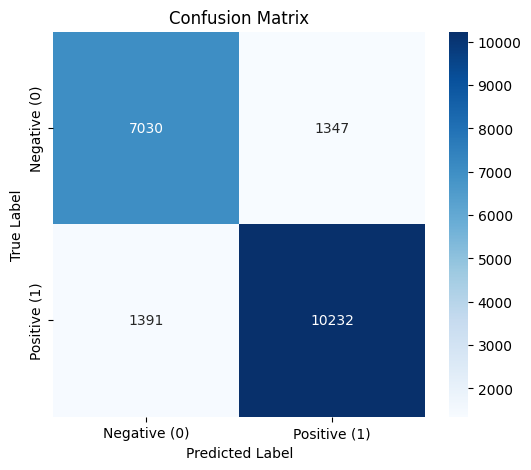

In [ ]:
y_pred = model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred, target_names=['Negative (0)', 'Positive (1)']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative (0)', 'Positive (1)'],
            yticklabels=['Negative (0)', 'Positive (1)'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Akurasi Training Set: 0.8979
Akurasi Testing Set: 0.8631


/tmp/ipython-input-95720108.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Set Data', y='Akurasi', data=performance, palette=['skyblue', 'salmon'])


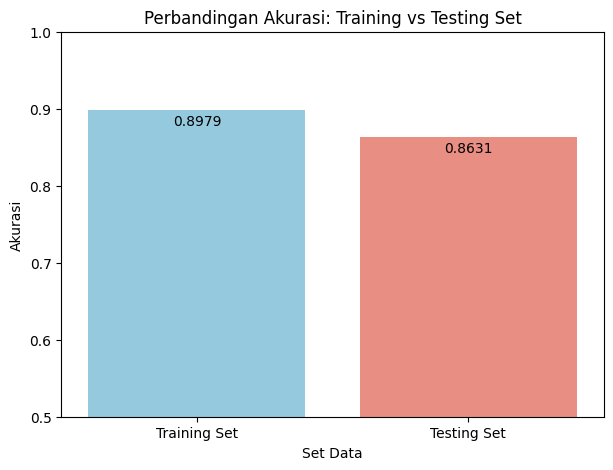

Grafik perbandingan akurasi.


In [ ]:
from sklearn.metrics import accuracy_score

y_train_pred = model.predict(X_train_tfidf)
train_accuracy = accuracy_score(y_train, y_train_pred)

test_accuracy = accuracy_score(y_test, y_pred)

print(f"Akurasi Training Set: {train_accuracy:.4f}")
print(f"Akurasi Testing Set: {test_accuracy:.4f}")

performance = pd.DataFrame({
    'Set Data': ['Training Set', 'Testing Set'],
    'Akurasi': [train_accuracy, test_accuracy]
})

plt.figure(figsize=(7, 5))
sns.barplot(x='Set Data', y='Akurasi', data=performance, palette=['skyblue', 'salmon'])
plt.title('Perbandingan Akurasi: Training vs Testing Set')
plt.ylim(0.5, 1.0)
plt.ylabel('Akurasi')

for index, row in performance.iterrows():
    plt.text(row.name, row.Akurasi - 0.02, f'{row.Akurasi:.4f}', color='black', ha="center")

plt.savefig('model_performance_comparison.png')
plt.show()

print("Grafik perbandingan akurasi.")

In [ ]:
X_all_tfidf = tfidf_vectorizer.transform(df['final_text'])

df['predicted_sentiment_label'] = model.predict(X_all_tfidf)

output_columns = [
    'content',
    'score',
    'text_lower',
    'text_clean',
    'text_token',
    'text_norm',
    'text_nostop',
    'text_stem',
    'final_text',
    'reviewCreatedVersion',
    'at',
    'appVersion',
    'predicted_sentiment_label'
]

df_final = df[output_columns].copy()

output_file_name = 'data_gojek_preprocessed_sentiment.csv'
df_final.to_csv(output_file_name, index=False)

print(f"Data akhir memiliki {len(df_final)} baris.")
print(f"File {output_file_name} disimpan")
files.download(output_file_name)

Data akhir memiliki 100000 baris.
File data_gojek_preprocessed_sentiment.csv disimpan


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>